[[2.0, 2.2, 2.4, 2.6, 2.8]]
[[2.0, 2.2, 2.4, 2.6, 2.8], [3.0, 3.2, 3.4, 3.6, 3.8, 4.0]]
[[2.0, 2.2, 2.4, 2.6, 2.8], [3.0, 3.2, 3.4, 3.6, 3.8, 4.0], [4.2, 4.4]]


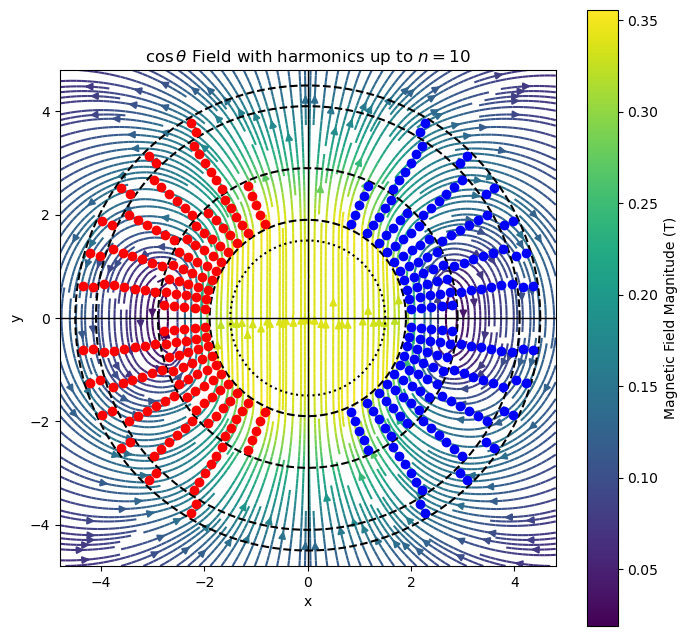

1.9
2.9


In [10]:
import numpy as np
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from scipy.stats import norm
import panel as pn
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('TkAgg')  # Or 'Qt5Agg', 'WebAgg', etc.

# Max harmonic we want the calculation to go up to:
# 1 = dipole, 2 = quadrupole, 3 = sextupole, etc.
n_max = 10
# Current magnitude
I0 = 16000
# Vacuum permeability
mu0 = 4 * np.pi * 1e-7
# Radius from origin as starting point (inner layer)
# Outter radius is controlled by amount of condutors present in block


# Reference Radius (Good Field Region): -> No calculations are done here yet, this is just for visualization
ref_rad = 1.5
# Aperture radius:
r0 = 2
# Radial spacing between conductors
dr = 0.2 
# Inner wall radius
inner_radius = r0 - dr/2

# Number of "wires" in each layer section (cable)
n_radial = [5, 6, 2]
# First layer radius:
outer_radius = (r0 + (n_radial[0] - 1) * dr) + dr/2

# Total number of blocks (divide by 4 to get number of blocks per quadrant) for each layer
"""
num_conductors_per_quad = 10
num_conductors_per_quad_layer_2 = 5
"""
# A list of the numbers of conductors in each layer:
num_cond_quad = [10, 5, 6] # Rename to "cables"

"""
num_conductors = num_conductors_per_quad*4
num_conductors_layer_2 = num_conductors_per_quad_layer_2*4
"""

# Number of conductors per layer:
num_conductors = 4*num_cond_quad

# Number of conductors per block
#n_radial = 5

# Creats a list of radii for each layer so it can plot correctly (layer boundary dashed line) (BROKEN)
# This is the dashed boundary line
"""
layer_radii_boundary = []
for i in range(len(n_radial)):
    layer_radius_boundary = inner_radius + (i)*(outer_radius-inner_radius)
    layer_radii_boundary.append(layer_radius)

print(layer_radii_boundary)
"""
    

# 2nd layer radius
# n layer = inner_radius + n*(outer_radius-inner_radius)
"""
layer_2_rad = inner_radius + 2*(outer_radius-inner_radius)
layer_3_rad = inner_radius + 3*(outer_radius-inner_radius)
"""


def B_harm(x, y, x_a, y_a, I):
    # Position of the conductor
    a = np.sqrt(x_a**2 + y_a**2)
    # Position of field measurement
    r = np.sqrt(x**2 + y**2)

    # Angle between a and y=0
    phi = np.arctan2(y_a, x_a)
    # Angle between r and y=0
    theta = np.arctan2(y, x)

    # Angle between r and a
    ang = phi - theta

    # Replace r=0 with r=1e-20 to avoid divsion by zero
    r = np.where(r == 0, 1e-10, r)

    # Now we compute the field for both cases, adding up harmonics until the n_max harmonic is calculated and added

    # Case for r < a:
    B_r_in = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.sin(n * ang) for n in range(1, n_max+1)], axis=0)
    B_theta_in = (-1)*((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.cos(n * ang) for n in range(1, n_max+1)], axis=0)
    
    # Case for r > a:
    B_r_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.sin(n * ang) for n in range(0, n_max+1)], axis=0)
    B_theta_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.cos(n * ang) for n in range(0, n_max+1)], axis=0)

    # Use np.where to select the correct field values to return
    # np.where(cond., x, y) -> # If true, takes x; if false, takes y
    B_r = np.where(r > a, B_r_out, B_r_in)
    B_theta = np.where(r > a, B_theta_out, B_theta_in)

    # Convert to cartesian coordinates (notably using the angle theta, not ang)
    B_x = B_r * np.cos(theta) - B_theta * np.sin(theta)
    B_y = B_r * np.sin(theta) + B_theta * np.cos(theta)

    return B_x, B_y


# List of angles following a cosine theta distribution, symmetric about y axis

# Uniformly spaced cumulative values (excluding 0 and 1 to avoid endpoints)
u_list = []
for i in range(len(num_cond_quad)):
    u_list.append(np.linspace(0, 1, num_cond_quad[i] + 2)[1:-1])

"""
u1 = np.linspace(0, 1, num_cond_quad[0] + 2)[1:-1]
u2 = np.linspace(0, 1, num_cond_quad[1] + 2)[1:-1]
"""

def theta_list_maker(u):
    # Inverse CDF: arcsin(2u - 1) maps uniform u to theta
    theta_right = np.arcsin(u)         # Density function for 1st quadrant, from [0, pi]
    theta_left = np.pi - theta_right           # Reflect to left side for symmetry
    theta_bot_left = (-1)*theta_left # To reflect polor coords: (r, theta) -> (r, -theta)
    theta_bot_right = (-1)*theta_right
    
    theta_list = np.sort(np.concatenate([theta_right, theta_left, theta_bot_left, theta_bot_right]))
    return theta_list

# Creates a master list of the theta distributions for each layer:
parent_theta_list = []
for i in range(len(u_list)):
    parent_theta_list.append(theta_list_maker(u_list[i]))

"""
thet_1 = theta_list_maker(u1)
thet_2 = theta_list_maker(u2)
"""

################# ISSUE IS HERE IN RADII DEFINITION ########################

# Determines the position of the conductors from the given angles
# For the first required layer: (This is correct)
"""
layer_radii = []

radii = [r0 + i * dr for i in range(n_radial[0])]
layer_radii.append(radii)
print(radii)

# Creates a list of values of the wire radial positions in each layer 
#layer_radii = []
for i in range(len(n_radial)):
    layer_radius = [ (outer_radius + dr/2 + i * dr) for i in range(n_radial[i]) ] # Supposed to be like 1-5
    layer_radii.append(layer_radius)

print(layer_radii)
"""

# Determines the radial position of each layer group of conductors in each layer
# Recall: n_radial = [5, 6, 2] -> Number of "wires" in each layer section (cable)
layer_radii = []
for j in range(len(n_radial)):
    if j == 0: # First layer radii values
        layer_radii.append( [r0 + i * dr for i in range(n_radial[0])] )
    else: # All other layer radii values, adds to the top of the last layer
        layer_radii.append( [(layer_radii[j-1][-1] + dr + i * dr) for i in range(n_radial[j])] ) # BROKEN, need to start at the previous layer rad
    print(layer_radii)

# Maps out the wires and how they should be distributed
# Current stays constant in magntitude for each conductor

def wire_params(theta_list, radii_list):
    wire_params = []
    for theta in theta_list:
        for r in radii_list:
            x = r * np.cos(theta)
            y = r * np.sin(theta)
    
            # Determine current direction by quadrant
            if x > 0:
                current = (-1)*I0  # Q1 & Q4 (right side)
            elif x < 0:
                current = I0   # Q2 & Q3 (left side)
            else:
                current = 0  # Edge case
            wire_params.append((x, y, current))
    return wire_params

# Make a wire params parent list via looping here
"""
wire_params_1 = wire_params(thet_1, radii)
wire_params_2 = wire_params(thet_2, radii_layer_2)
"""

total_wire_params = []
for i in range(len(layer_radii)):
    total_wire_params.append(wire_params(parent_theta_list[i], layer_radii[i]))

# B-field components are computed
# We set them up as arrays with the same dimensions as X and Y

# bounds = [ x min & max, y min & max ]
# Used for both field calculation and plotting to minimize computation

bounds = [ [-4.8, 4.8], 
           [-4.8, 4.8] 
         ]

# Automatically set bounds to allow viewing of all layers

# Grid setup (for plotting the field)
# The field is always calculated everywhere in this region
x = np.linspace(bounds[0][0], bounds[0][1], 250)
y = np.linspace(bounds[1][0], bounds[1][1], 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

#iterate over wire params parent list
# Calculate field for each wire component

for params in total_wire_params:
    for x0, y0, I in params:
        Bx, By = B_harm(X, Y, x0, y0, I)
        Bx_total += Bx
        By_total += By

"""
for x0, y0, I in wire_params_1:
    Bx, By = B_harm(X, Y, x0, y0, I)
    Bx_total += Bx
    By_total += By

for x0, y0, I in wire_params_2:
    Bx, By = B_harm(X, Y, x0, y0, I)
    Bx_total += Bx
    By_total += By
"""

# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

####################################################################################
# Plotting

plt.figure(figsize=(8, 8))

# Stream plot of magnetic field
# Only shows 95th percentile as max to make line magnitudes easier to see
#norm = mcolors.Normalize(vmin=B_mag.min(), vmax=np.percentile(B_mag, 95)) 
strm = plt.streamplot(X, Y, Bx_total, By_total, color=B_mag, cmap='viridis', density=3, zorder=0)
cbar = plt.colorbar(strm.lines, label='Magnetic Field Magnitude (T)')

for params in total_wire_params:
    for x0, y0, I in params:
        color = 'r' if I > 0 else 'b'
        plt.plot(x0, y0, 'o', color=color, zorder=2)

"""
# Plot conductors
for x0, y0, I in wire_params_1:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color, zorder=2)
# Plot conductors
for x0, y0, I in wire_params_2:
    color = 'r' if I > 0 else 'b'
    plt.plot(x0, y0, 'o', color=color, zorder=2)
"""

# Defines the angular space to plot the cirles
theta_circle = np.linspace(0, 2*np.pi, 500)

# Plot of the reference radius
x_ref = ref_rad * np.cos(theta_circle)
y_ref = ref_rad * np.sin(theta_circle)
plt.plot(x_ref, y_ref, 'k:', zorder=1)

# Draw inner circle
x_circle = inner_radius * np.cos(theta_circle)
y_circle = inner_radius * np.sin(theta_circle)
plt.plot(x_circle, y_circle, 'k--', zorder=1)

# Draw outer circle to contain all conductors (defined by number of conductors)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_outer, y_outer, 'k--', zorder=1)

# Radius = last point + dr

for i in range(len(layer_radii)):
    if i == 0: # Skip the first layer since that plots earlier
        pass
    else: 
        x_layer = (layer_radii[i][-1]+dr/2) * np.cos(theta_circle) # The [-1] index accesses the last value in the list
        y_layer = (layer_radii[i][-1]+dr/2) * np.sin(theta_circle)
        plt.plot(x_layer, y_layer, 'k--', zorder=1)



"""
# Draw 2nd layer circle
x_layer_2 = layer_2_rad * np.cos(theta_circle)
y_layer_2 = layer_2_rad * np.sin(theta_circle)
plt.plot(x_layer_2, y_layer_2, 'k--', zorder=1)

x_layer_3 = layer_3_rad * np.cos(theta_circle)
y_layer_3 = layer_3_rad * np.sin(theta_circle)
plt.plot(x_layer_3, y_layer_3, 'k--', zorder=1)
"""

# Axes & final layout
plt.axhline(0, color='black', linewidth=1, zorder=1)
plt.axvline(0, color='black', linewidth=1, zorder=1)
plt.gca().set_aspect('equal')
plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"$\\cos \\theta$ Field with harmonics up to $n=${n_max}")
plt.show()

print(inner_radius)
print(outer_radius)

# Cleaned Version:

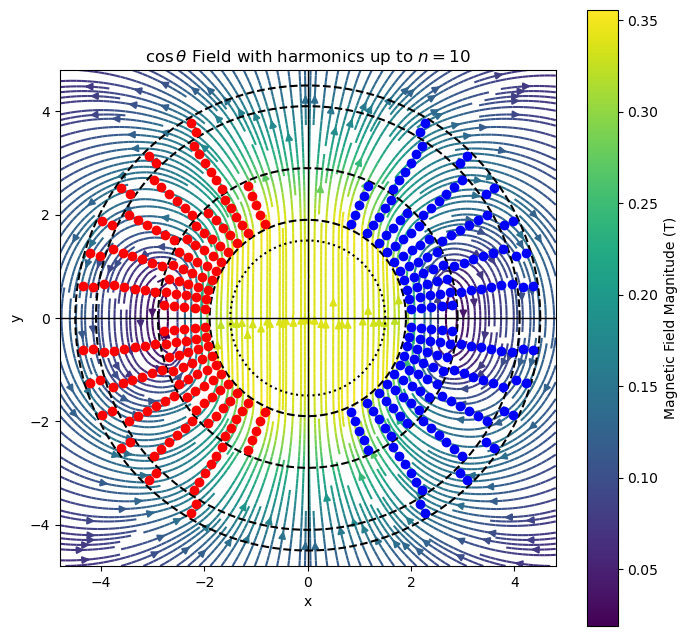

In [13]:
#################################### LIBRARY IMPORTS ##########################################
import numpy as np
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from scipy.stats import norm
import panel as pn
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('TkAgg')  # Or 'Qt5Agg', 'WebAgg', etc.

#################################### CONSTANTS ##########################################
# Max harmonic we want the calculation to go up to: 1 = dipole, 2 = quadrupole, 3 = sextupole, etc.
n_max = 10

# Current magnitude
I0 = 16000

# Vacuum permeability
mu0 = 4 * np.pi * 1e-7

# Reference Radius (Good Field Region): -> No calculations are done here yet, this is just for visualization
ref_rad = 1.5

# Radius at which points will start to plot in the first layer:
r0 = 2

# Radial spacing between conductors
dr = 0.2 

# Number of "wires" in each layer's cable
n_radial = [5, 6, 2]
# A list of the numbers of cables in each layer (per quadrant):
num_cond_quad = [10, 5, 6] 

# Aperture radius:
inner_radius = r0 - dr/2

# First layer radius:
# Controlled by amount of condutors present in block
outer_radius = (r0 + (n_radial[0] - 1) * dr) + dr/2

# Total number of conductors per layer:
num_conductors = 4*num_cond_quad

###################################### FUNCTIONS ########################################
# Functions used for all the calculations:

# Uses the non-ideal B-field equation to calculate the field everywhere in the X, Y space due to a conductor at (x_a, y_a)
def B_harm(x, y, x_a, y_a, I):
    # Position of the conductor
    a = np.sqrt(x_a**2 + y_a**2)
    # Position of field measurement
    r = np.sqrt(x**2 + y**2)

    # Angle between a and y=0
    phi = np.arctan2(y_a, x_a)
    # Angle between r and y=0
    theta = np.arctan2(y, x)

    # Angle between r and a
    ang = phi - theta

    # Replace r=0 with r=1e-20 to avoid divsion by zero
    r = np.where(r == 0, 1e-10, r)

    # Now we compute the field for both cases, adding up harmonics until the n_max harmonic is calculated and added

    # Case for r < a:
    B_r_in = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.sin(n * ang) for n in range(1, n_max+1)], axis=0)
    B_theta_in = (-1)*((mu0 * I) / (2 * np.pi * a)) * np.sum([(r / a)**(n - 1) * np.cos(n * ang) for n in range(1, n_max+1)], axis=0)
    
    # Case for r > a:
    B_r_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.sin(n * ang) for n in range(0, n_max+1)], axis=0)
    B_theta_out = ((mu0 * I) / (2 * np.pi * a)) * np.sum([(a / r)**(n + 1) * np.cos(n * ang) for n in range(0, n_max+1)], axis=0)

    # Use np.where to select the correct field values to return
    # np.where(cond., x, y) -> # If true, takes x; if false, takes y
    B_r = np.where(r > a, B_r_out, B_r_in)
    B_theta = np.where(r > a, B_theta_out, B_theta_in)

    # Convert to cartesian coordinates (notably using the angle theta, not ang)
    B_x = B_r * np.cos(theta) - B_theta * np.sin(theta)
    B_y = B_r * np.sin(theta) + B_theta * np.cos(theta)

    return B_x, B_y

# Makes a list of all the angular values following a cos theta distribution for a given number of conductors
def theta_list_maker(u):
    # Inverse CDF for cos theta distribution: arcsin(2u - 1) maps uniform u to theta
    theta_right = np.arcsin(u) # Density function for 1st quadrant, from [0, pi]
    theta_left = np.pi - theta_right # Reflect to left side for symmetry
    theta_bot_left = (-1)*theta_left # To reflect polor coords: (r, theta) -> (r, -theta)
    theta_bot_right = (-1)*theta_right
    
    theta_list = np.sort(np.concatenate([theta_right, theta_left, theta_bot_left, theta_bot_right])) # Combines values for each quandrant into one list
    return theta_list

# Given an angular distribution and a list of radial values, it assigns an (x, y) value to the conductor and a current depending on the hemisphere
def wire_params(theta_list, radii_list):
    wire_params = []
    for theta in theta_list:
        for r in radii_list:
            x = r * np.cos(theta)
            y = r * np.sin(theta)
    
            # Determine current direction by quadrant
            if x > 0:
                current = (-1)*I0  # Q1 & Q4 (right side)
            elif x < 0:
                current = I0   # Q2 & Q3 (left side)
            else:
                current = 0  # Edge case
            wire_params.append((x, y, current))
    return wire_params

###################################### CALCULATIONS ########################################

# Uniformly spaced cumulative values (excluding 0 and 1 to avoid endpoints)

# Creates a master list of the sample region, which is based on the number of conductors:
u_list = []
for i in range(len(num_cond_quad)):
    u_list.append(np.linspace(0, 1, num_cond_quad[i] + 2)[1:-1])

# Creates a master list of the theta distributions for each layer, which is based on the sampling region we just determined:
parent_theta_list = []
for i in range(len(u_list)):
    parent_theta_list.append(theta_list_maker(u_list[i]))

# Calculates the radial position of each wire in each layer
# Determines the radial position of each layer group of conductors in each layer
# Recall: n_radial = [5, 6, 2] -> Number of "wires" in each layer section (cable)
layer_radii = []
for j in range(len(n_radial)):
    if j == 0: # First layer radii values
        layer_radii.append( [r0 + i * dr for i in range(n_radial[0])] )
    else: # All other layer radii values, adds to the top of the last layer
        layer_radii.append( [(layer_radii[j-1][-1] + dr + i * dr) for i in range(n_radial[j])] ) # BROKEN, need to start at the previous layer rad)

# Maps out the wires and how they should be distributed
# Current stays constant in magntitude for each conductor

# Creates a parent list of the wire params list, this will allow us to plot easier:
total_wire_params = []
for i in range(len(layer_radii)):
    total_wire_params.append(wire_params(parent_theta_list[i], layer_radii[i]))

# bounds = [ x min & max, y min & max ]
# Used for both field calculation and plotting to minimize computation
bounds = [ [-4.8, 4.8], 
           [-4.8, 4.8] 
         ]

# Automatically set bounds to allow viewing of all layers

# Grid setup
# The field is always calculated everywhere in this region
x = np.linspace(bounds[0][0], bounds[0][1], 250)
y = np.linspace(bounds[1][0], bounds[1][1], 250)
X, Y = np.meshgrid(x, y)

Bx_total = np.zeros_like(X)
By_total = np.zeros_like(Y)

# Calculate field due to each wire configuration given by wire params parent list
for params in total_wire_params:
    for x0, y0, I in params:
        Bx, By = B_harm(X, Y, x0, y0, I)
        Bx_total += Bx
        By_total += By

# Total B-field magnitudes are computed
B_mag = np.sqrt(Bx_total**2 + By_total**2)

###################################### PLOTTING ########################################

plt.figure(figsize=(8, 8))

# Stream plot of magnetic field
# Only shows 95th percentile as max to make line magnitudes easier to see
#norm = mcolors.Normalize(vmin=B_mag.min(), vmax=np.percentile(B_mag, 95)) 
strm = plt.streamplot(X, Y, Bx_total, By_total, color=B_mag, cmap='viridis', density=3, zorder=0)
cbar = plt.colorbar(strm.lines, label='Magnetic Field Magnitude (T)')

# plot the positions of each wire
for params in total_wire_params:
    for x0, y0, I in params:
        color = 'r' if I > 0 else 'b'
        plt.plot(x0, y0, 'o', color=color, zorder=2)

# Defines the angular space to plot the cirles
theta_circle = np.linspace(0, 2*np.pi, 500)

# Plot of the reference radius
x_ref = ref_rad * np.cos(theta_circle)
y_ref = ref_rad * np.sin(theta_circle)
plt.plot(x_ref, y_ref, 'k:', zorder=1)

# Draw inner circle
x_circle = inner_radius * np.cos(theta_circle)
y_circle = inner_radius * np.sin(theta_circle)
plt.plot(x_circle, y_circle, 'k--', zorder=1)

# Draw outer circle to contain all conductors (defined by number of conductors)
x_outer = outer_radius * np.cos(theta_circle)
y_outer = outer_radius * np.sin(theta_circle)
plt.plot(x_outer, y_outer, 'k--', zorder=1)

# Layer radius = last point + dr/2

# Plots the radius of each layer
for i in range(len(layer_radii)):
    if i == 0: # Skip the first layer since that plots earlier
        pass
    else: 
        x_layer = (layer_radii[i][-1]+dr/2) * np.cos(theta_circle) # The [-1] index accesses the last value in the list
        y_layer = (layer_radii[i][-1]+dr/2) * np.sin(theta_circle)
        plt.plot(x_layer, y_layer, 'k--', zorder=1)

# Axes & final layout
plt.axhline(0, color='black', linewidth=1, zorder=1)
plt.axvline(0, color='black', linewidth=1, zorder=1)
plt.gca().set_aspect('equal')
plt.xlim(bounds[0][0], bounds[0][1])
plt.ylim(bounds[1][0], bounds[1][1])
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"$\\cos \\theta$ Field with harmonics up to $n=${n_max}")
plt.show()

In [ ]:
# Make everything more customizable as per user input
# Maybe make a magnet class and each kind of magnet can be created from the specs provided there ?
# This would also allow creation of higher order magnets

# Need to double check what parameters should be varied for optimization
# Need to check how blocks should be distributed according to cosine theta dist.

# Have magnets be the parent class to all the different types of magnets

In [ ]:
class Person:
  def __init__(self, name, age): # Values that you use when you instantiate the class and create an object
    self.name = name
    self.age = age

  def myfunc(self):
    print("Hello my name is " + self.name)

p1 = Person("John", 36)
p1.myfunc()



In [ ]:
class Circle:
    def __init__(self, radius, color):
        self.radius = radius
        self.color = color 
    def Draw(self):
        theta_circle = np.linspace(0, 2*np.pi, 500)
        x = self.radius*np.cos(theta_circle)
        y = self.radius*np.sin(theta_circle)
        plt.plot(x, y, color=self.color, zorder=1)

In [ ]:
circ=Circle(5, "blue")
circ.Draw()

In [ ]:
class Magnet:
    def __init__(self):
        self.ref_rad = ref_rad
        self.inner_rad = inner_rad
        self.outer_rad = outer_rad
    def CondLayout(self):

    def WireParams(self):

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import panel as pn

pn.extension()

# Input widgets
radius_input = pn.widgets.FloatInput(name='Radius', value=1.0, step=0.1, start=0.1)
color_dropdown = pn.widgets.Select(name='Color', options=['red', 'blue', 'green', 'black'], value='blue')
plot_button = pn.widgets.Button(name='Plot Circle', button_type='primary')

# Output pane
plot_pane = pn.pane.Matplotlib(tight=True)

# Plotting function
def plot_circle(radius, color):
    fig, ax = plt.subplots()
    circle = plt.Circle((0, 0), radius, color=color, fill=False, linewidth=2)
    ax.add_patch(circle)
    ax.set_xlim(-radius - 1, radius + 1)
    ax.set_ylim(-radius - 1, radius + 1)
    ax.set_aspect('equal', 'box')
    ax.set_title(f'Circle with radius {radius} and color {color}')
    return fig

# Callback function for button
def update_plot(event):
    radius = radius_input.value
    color = color_dropdown.value
    fig = plot_circle(radius, color)
    plot_pane.object = fig

plot_button.on_click(update_plot)

# Layout
layout = pn.Column(
    pn.pane.Markdown("## Circle Plotter"),
    pn.Row(radius_input, color_dropdown, plot_button),
    plot_pane
)

# Serve or display
layout.servable()


In [ ]:
import numpy as np
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from scipy.stats import norm
import panel as pn
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Max harmonic we want the calculation to go up to:
# 1 = dipole, 2 = quadrupole, 3 = sextupole, etc.
n_max = 10
# Current magnitude
I0 = 16000
# Vacuum permeability
mu0 = 4 * np.pi * 1e-7
# Radius from origin as starting point (inner layer)
# Outter radius is controlled by amount of condutors present in block


# Reference Radius (Good Field Region):
ref_rad = 1.5
# Aperture radius:
r0 = 2
# Radial spacing between conductors
dr = 0.2 
# Inner wall radius
inner_radius = r0 - dr/2


# Total number of blocks (divide by 4 to get number of blocks per quadrant) for each layer
num_conductors_per_quad = 10
num_conductors_per_quad_layer_2 = 5
# A list of the numbers of conductors in each layer:
num_cond_quad = [10, 5]

num_conductors = num_conductors_per_quad*4
num_conductors_layer_2 = num_conductors_per_quad_layer_2*4
# Number of conductors per layer:
num_conductors = 4*num_cond_quad

# Number of conductors per block
#n_radial = 5
# Number of "wires" in each layer section
n_radial = [5, 3, 6]

layer_radii = []
outer_radius = (r0 + (n_radial[0] - 1) * dr) + dr/2
for i in range(len(n_radial)):
    # Outer radius:
    layer_radius = inner_radius + (i+1)*(outer_radius-inner_radius)
    layer_radii.append(layer_radius)
    

print(outer_radii)
print(layer_radii)

In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # Or 'Qt5Agg', 'WebAgg', etc.
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([1, 2, 3], [4, 5, 6])
plt.show()